<a href="https://colab.research.google.com/github/DeepLabCut/DeepLabCut/blob/main/examples/COLAB/COLAB_HumanPose_with_RTMPose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepLabCut RTMPose human pose estimation demo

Some useful links:

- DeepLabCut's GitHub: [github.com/DeepLabCut/DeepLabCut](https://github.com/DeepLabCut/DeepLabCut/tree/main)
- DeepLabCut's Documentation: [deeplabcut.github.io/DeepLabCut](https://deeplabcut.github.io/DeepLabCut/README.html)

This notebook illustrates how to use the cloud to run pose estimation on humans using a pre-trained [RTMPose](https://arxiv.org/abs/2303.07399) model. **⚠️Note: It uses DeepLabCut's low-level interface, so may be suited for more experienced users.⚠️**

RTMPose is a top-down pose estimation model, which means that bounding boxes must be obtained for individuals (which is usually done through an [object detection model](https://en.wikipedia.org/wiki/Object_detection)) before running pose estimation. We obtain bounding boxes using a pre-trained object detector provided by [`torchvision`](https://pytorch.org/vision/main/models.html#object-detection-instance-segmentation-and-person-keypoint-detection).

## Selecting the Runtime and Installing DeepLabCut

**First, go to "Runtime" ->"change runtime type"->select "Python3", and then select "GPU".**

Next, we need to install DeepLabCut and its dependencies.

In [ ]:
# this will take a couple of minutes to install all the dependencies!
!pip install --pre deeplabcut

**(Be sure to click "RESTART RUNTIME" if it is displayed above before moving on !) You will see this button at the output of the cells above ^.**

## Importing Packages and Downloading Model Snapshots

Next, we'll need to import `deeplabcut`, `huggingface_hub` and other dependencies needed to run the demo.

In [2]:
from pathlib import Path

import deeplabcut.pose_estimation_pytorch as dlc_torch
import huggingface_hub
import matplotlib.collections as collections
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models.detection as detection
from PIL import Image
from tqdm import tqdm

Loading DLC 3.0.0rc10...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


We can now download the pre-trained RTMPose model weights with which we'll run pose estimation.

In [3]:
# Folder in COLAB where snapshots will be saved
model_files = Path("hf_files").resolve()
model_files.mkdir(exist_ok=True)

# Download the snapshot and model configuration file
#   This is generic code to download any snapshot from HuggingFace
#   To download DeepLabCut SuperAnimal or Model Zoo models, check
#   out dlclibrary!
path_model_config = Path(
    huggingface_hub.hf_hub_download(
        "DeepLabCut/HumanBody",
        "rtmpose-x_simcc-body7_pytorch_config.yaml",
        local_dir=model_files,
    )
)
path_snapshot = Path(
    huggingface_hub.hf_hub_download(
        "DeepLabCut/HumanBody",
        "rtmpose-x_simcc-body7.pt",
        local_dir=model_files,
    )
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


We'll now also define some parameters that we'll later use to plot predictions:

- a colormap for the keypoints to plot
- a colormap for the limbs of the skeleton
- a skeleton for the model


In [4]:
cmap_keypoints = plt.get_cmap("rainbow")
cmap_skeleton = plt.get_cmap("rainbow_r")

bodyparts2connect = [
    ("right_ankle", "right_knee"),
    ("right_knee", "right_hip"),
    ("left_ankle", "left_knee"),
    ("left_hip", "left_knee"),
    ("left_hip", "right_hip"),
    ("right_shoulder", "right_hip"),
    ("left_shoulder", "left_hip"),
    ("left_shoulder", "right_shoulder"),
    ("left_shoulder", "left_elbow"),
    ("right_shoulder", "right_elbow"),
    ("left_elbow", "left_wrist"),
    ("right_elbow", "right_wrist"),
    ("right_eye", "left_ear"),
    ("left_eye", "right_eye"),
    ("left_eye", "left_ear"),
    ("right_eye", "right_ear"),
    ("left_ear", "left_shoulder"),
    ("right_ear", "right_shoulder"),
    ("left_shoulder", "left_elbow"),
    ("right_shoulder", "right_elbow"),
]
skeleton = [
    [16, 14],
    [14, 12],
    [17, 15],
    [15, 13],
    [12, 13],
    [6, 12],
    [7, 13],
    [6, 7],
    [6, 8],
    [7, 9],
    [8, 10],
    [9, 11],
    [2, 3],
    [1, 2],
    [1, 3],
    [2, 4],
    [3, 5],
    [4, 6],
    [5, 7],
]

## Running Inference on Images

First, let's upload some images to run inference on. To do so, you can just run the cell below.

In [5]:
from google.colab import files

#JPG or PNG is recommended:
uploaded = files.upload()
for filepath, content in uploaded.items():
    print(f"User uploaded file '{filepath}' with length {len(content)} bytes")

image_paths = [Path(filepath).resolve() for filepath in uploaded.keys()]

# If this cell fails (e.g., when using Safari in place of Google Chrome),
# manually upload your image via the Files menu to the left and define
# `image_paths` yourself with right `click` > `copy path` on the image:
#
# image_paths = [
#   Path("/path/to/my/image_000.png"),
#   Path("/path/to/my/image_001.png"),
# ]


Saving taylor_swift.jpg to taylor_swift.jpg
User uploaded file 'taylor_swift.jpg' with length 46915 bytes


In [6]:
# Define the device on which the models will run
device = "cuda"  # e.g. cuda, cpu

# The maximum number of detections to keep in an image
max_detections = 10

#############################################
# Run a pretrained detector to get bounding boxes

# Load the detector from torchvision
weights = detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
detector = detection.fasterrcnn_mobilenet_v3_large_fpn(
    weights=weights, box_score_thresh=0.6,
)
detector.eval()
detector.to(device)
preprocess = weights.transforms()

# The context is a list containing the bounding boxes predicted
# for each image; it will be given to the RTMPose model alongside
# the images.
context = []

print("Running object detection")
with torch.no_grad():
    for image_path in tqdm(image_paths):
        image = Image.open(image_path).convert("RGB")
        batch = [preprocess(image).to(device)]
        predictions = detector(batch)[0]
        bboxes = predictions["boxes"].cpu().numpy()
        labels = predictions["labels"].cpu().numpy()

        # Obtain the bounding boxes predicted for humans
        human_bboxes = [
            bbox for bbox, label in zip(bboxes, labels) if label == 1
        ]

        # Convert bounding boxes to xywh format
        bboxes = np.zeros((0, 4))
        if len(human_bboxes) > 0:
            bboxes = np.stack(human_bboxes)
        bboxes[:, 2] -= bboxes[:, 0]
        bboxes[:, 3] -= bboxes[:, 1]

        # Only keep the best N detections
        bboxes = bboxes[:max_detections]

        context.append({"bboxes": bboxes})


#############################################
# Run inference on the images
pose_cfg = dlc_torch.config.read_config_as_dict(path_model_config)
runner = dlc_torch.get_pose_inference_runner(
    pose_cfg,
    snapshot_path=path_snapshot,
    batch_size=16,
    max_individuals=max_detections,
)

print("Running pose estimation")
predictions = runner.inference(tqdm(zip(image_paths, context)))


#############################################
# Create a DataFrame with the predictions, and save them to a CSV file.
print("Saving the predictions to a CSV file")
df = dlc_torch.build_predictions_dataframe(
    scorer="rtmpose-body7",
    predictions={
        img_path: img_predictions
        for img_path, img_predictions in zip(image_paths, predictions)
    },
    parameters=dlc_torch.PoseDatasetParameters(
        bodyparts=pose_cfg["metadata"]["bodyparts"],
        unique_bpts=pose_cfg["metadata"]["unique_bodyparts"],
        individuals=[f"idv_{i}" for i in range(max_detections)]
    )
)

# Save to CSV
df.to_csv("image_predictions.csv")

print("Done!")

Running object detection


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Running pose estimation


1it [00:00, 78.27it/s]


Saving the predictions to a CSV file
Done!


Finally, we can plot the predictions!

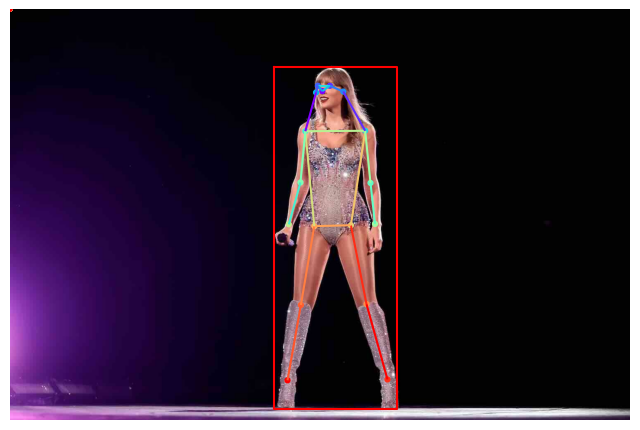

In [7]:
#############################################
# Unpack and plot predictions
plot_skeleton = True
plot_pose_markers = True
plot_bounding_boxes = True
marker_size = 12

for image_path, image_predictions in zip(image_paths, predictions):
    image = Image.open(image_path).convert("RGB")

    pose = image_predictions["bodyparts"]
    bboxes = image_predictions["bboxes"]
    num_individuals, num_bodyparts = pose.shape[:2]

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image)
    ax.set_xlim(0, image.width)
    ax.set_ylim(image.height, 0)
    ax.axis("off")
    for idv_pose in pose:
        if plot_skeleton:
            bones = []
            for bpt_1, bpt_2 in skeleton:
                bones.append([idv_pose[bpt_1 - 1, :2], idv_pose[bpt_2 - 1, :2]])

            bone_colors = cmap_skeleton
            if not isinstance(cmap_skeleton, str):
                bone_colors = cmap_skeleton(np.linspace(0, 1, len(skeleton)))

            ax.add_collection(
                collections.LineCollection(bones, colors=bone_colors)
            )

        if plot_pose_markers:
            ax.scatter(
                idv_pose[:, 0],
                idv_pose[:, 1],
                c=list(range(num_bodyparts)),
                cmap="rainbow",
                s=marker_size,
            )

    if plot_bounding_boxes:
        for x, y, w, h in bboxes:
            ax.plot(
                [x, x + w, x + w, x, x],
                [y, y, y + h, y + h, y],
                c="r",
            )

    plt.show()

## Running Inference on a Video

Running pose inference on a video is very similar! First, upload a video to Google Drive.

In [8]:
from google.colab import files

uploaded = files.upload()
for filepath, content in uploaded.items():
    print(f"User uploaded file '{filepath}' with length {len(content)} bytes")


video_path = [Path(filepath).resolve() for filepath in uploaded.keys()][0]

# If this cell fails (e.g., when using Safari in place of Google Chrome),
# manually upload your video via the Files menu to the left and define
# `video_path` yourself with right `click` > `copy path` on the video:
#
# video_path = Path("/path/to/my/video.mp4")


Saving taylor-dancing.mov to taylor-dancing.mov
User uploaded file 'taylor-dancing.mov' with length 1415324 bytes


In [9]:
# Define the device on which the models will run
device = "cuda"  # e.g. cuda, cpu

# The maximum number of individuals to detect in an image
max_detections = 30


#############################################
# Create a video iterator
video = dlc_torch.VideoIterator(video_path)


#############################################
# Run a pretrained detector to get bounding boxes

# Load the detector from torchvision
weights = detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
detector = detection.fasterrcnn_mobilenet_v3_large_fpn(
    weights=weights, box_score_thresh=0.6,
)
detector.eval()
detector.to(device)
preprocess = weights.transforms()

# The context is a list containing the bounding boxes predicted for each frame
# in the video.
context = []

print("Running object detection")
with torch.no_grad():
    for frame in tqdm(video):
        batch = [preprocess(Image.fromarray(frame)).to(device)]
        predictions = detector(batch)[0]
        bboxes = predictions["boxes"].cpu().numpy()
        labels = predictions["labels"].cpu().numpy()

        # Obtain the bounding boxes predicted for humans
        human_bboxes = [
            bbox for bbox, label in zip(bboxes, labels) if label == 1
        ]

        # Convert bounding boxes to xywh format
        bboxes = np.zeros((0, 4))
        if len(human_bboxes) > 0:
            bboxes = np.stack(human_bboxes)
        bboxes[:, 2] -= bboxes[:, 0]
        bboxes[:, 3] -= bboxes[:, 1]

        # Only keep the top N bounding boxes
        bboxes = bboxes[:max_detections]

        context.append({"bboxes": bboxes})

# Set the context for the video
video.set_context(context)


#############################################
# Run inference on the images (in this case a single image)
pose_cfg = dlc_torch.config.read_config_as_dict(path_model_config)
runner = dlc_torch.get_pose_inference_runner(
    pose_cfg,
    snapshot_path=path_snapshot,
    batch_size=16,
    max_individuals=max_detections,
)

print("Running pose estimation")
predictions = runner.inference(tqdm(video))


print("Saving the predictions to a CSV file")
df = dlc_torch.build_predictions_dataframe(
    scorer="rtmpose-body7",
    predictions={
        idx: img_predictions
        for idx, img_predictions in enumerate(predictions)
    },
    parameters=dlc_torch.PoseDatasetParameters(
        bodyparts=pose_cfg["metadata"]["bodyparts"],
        unique_bpts=pose_cfg["metadata"]["unique_bodyparts"],
        individuals=[f"idv_{i}" for i in range(max_detections)]
    )
)
df.to_csv("video_predictions.csv")

print("Done!")

Running object detection


 81%|████████▏ | 66/81 [00:02<00:00, 25.37it/s]


Running pose estimation


 81%|████████▏ | 66/81 [00:01<00:00, 53.25it/s]


Saving the predictions to a CSV file
Done!


Finally, we can plot the predictions on the video! The labeled video output is saved in the `"video_predictions.mp4"` file, and can be downloaded to be viewed.

In [10]:
from deeplabcut.utils.make_labeled_video import CreateVideo
from deeplabcut.utils.video_processor import VideoProcessorCV

video_output_path = "video_predictions.mp4"

clip = VideoProcessorCV(str(video_path), sname=video_output_path, codec="mp4v")
CreateVideo(
    clip,
    df,
    pcutoff=0.4,
    dotsize=3,
    colormap="rainbow",
    bodyparts2plot=pose_cfg["metadata"]["bodyparts"],
    trailpoints=0,
    cropping=False,
    x1=0,
    x2=clip.w,
    y1=0,
    y2=clip.h,
    bodyparts2connect=bodyparts2connect,
    skeleton_color="w",
    draw_skeleton=True,
    displaycropped=True,
    color_by="bodypart",
)

/usr/local/lib/python3.11/dist-packages/deeplabcut/utils/make_labeled_video.py:146: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  Dataframe.groupby(level="individuals", axis=1).size().values // 3


Duration of video [s]: 1.57, recorded with 51.7 fps!
Overall # of frames: 81 with cropped frame dimensions: 828 768
Generating frames and creating video.


100%|██████████| 66/66 [00:01<00:00, 35.27it/s]
